In [1]:
import pandas as pd
import numpy as np


In [2]:
# Load the dataset
df = pd.read_csv("/content/dataset.csv")

# Preview the data
df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [4]:
# Combine date and time into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

# Sort data by parking lot and timestamp
df = df.sort_values(by=['ID', 'Timestamp']).reset_index(drop=True)

In [5]:
# Constants
BASE_PRICE = 10.0
ALPHA = 2.0  # Sensitivity to occupancy

# Create a new column for price
df['Price'] = np.nan


In [6]:
# Group by parking lot
for lot_id, group in df.groupby('ID'):
    prices = []
    previous_price = BASE_PRICE

    for i, row in group.iterrows():
        occupancy = row['Occupancy']
        capacity = row['Capacity']

        # Avoid division by zero
        if capacity == 0:
            price = previous_price
        else:
            factor = occupancy / capacity
            price = previous_price + ALPHA * factor

        prices.append(price)
        previous_price = price

    # Assign calculated prices back
    df.loc[group.index, 'Price'] = prices


In [7]:
# View result for a specific parking lot
df[df['ID'] == df['ID'].iloc[0]][['Timestamp', 'Occupancy', 'Capacity', 'Price']].head(10)


,Timestamp,Occupancy,Capacity,Price
0,2016-10-04 07:59:00,61,577,10.211438


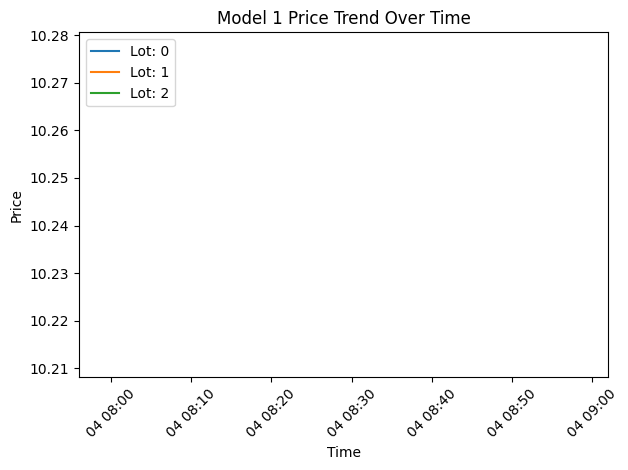

In [8]:
import matplotlib.pyplot as plt

# Select a few parking lot IDs
lot_ids = df['ID'].unique()[:3]  # First 3 lots

for lot in lot_ids:
    lot_df = df[df['ID'] == lot]
    plt.plot(lot_df['Timestamp'], lot_df['Price'], label=f'Lot: {lot}')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Model 1 Price Trend Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Choose a sample row
sample = df[df['ID'] == df['ID'].iloc[0]].iloc[0]  # Select the first record

print("Occupancy:", sample['Occupancy'])
print("Capacity:", sample['Capacity'])

# Find the index of the sample row within the filtered DataFrame
sample_index_in_lot = df[df['ID'] == sample['ID']].index.get_loc(sample.name)

# Check if there is a previous record in the filtered DataFrame
if sample_index_in_lot > 0:
    previous_price = df[df['ID'] == sample['ID']].iloc[sample_index_in_lot - 1]['Price']
    print("Previous Price:", previous_price)

    # Recalculate
    occupancy_ratio = sample['Occupancy'] / sample['Capacity']
    expected_price = previous_price + ALPHA * occupancy_ratio
    print("Expected Price:", expected_price)
else:
    print("This is the first record for this parking lot, no previous price to compare.")
    # If it's the first record, the price calculation starts from BASE_PRICE
    occupancy_ratio = sample['Occupancy'] / sample['Capacity']
    expected_price = BASE_PRICE + ALPHA * occupancy_ratio
    print("Expected Price (based on BASE_PRICE):", expected_price)

print("Current Price:", sample['Price'])

Occupancy: 61
Capacity: 577
This is the first record for this parking lot, no previous price to compare.
Expected Price (based on BASE_PRICE): 10.211438474870018
Current Price: 10.211438474870018


In [11]:
!pip install bokeh --quiet


In [13]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10
from bokeh.layouts import layout

output_notebook()

# Select top 3 unique parking lots
lot_ids = df['ID'].unique()[:3]

p = figure(title="Real-Time Price Trend (Model 1)",
           x_axis_label='Time',
           y_axis_label='Price ($)',
           x_axis_type='datetime',
           width=800, height=400)

colors = Category10[10]

for i, lot in enumerate(lot_ids):
    lot_df = df[df['ID'] == lot]
    source = ColumnDataSource(data={
        'x': lot_df['Timestamp'],
        'y': lot_df['Price']
    })

    p.line('x', 'y', source=source, line_width=2, color=colors[i], legend_label=f'Lot: {lot}')
    p.scatter('x', 'y', source=source, fill_color=colors[i], size=4)

p.legend.title = 'Parking Lot ID'
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.title.text_font_size = '16pt'

show(p)
